In [1]:
import csv
import networkx as nx
import numpy as np
from random import randint
import random
import csv
import networkx as nx
import numpy as np
from random import randint
from sklearn.linear_model import LogisticRegression
from xgboost import plot_importance


EDGE_LIST_PATH = '../input/citation-prediction-altegrad/edgelist.txt'
AUTHORS_LIST_PATH = '../input/citation-prediction-altegrad/authors.txt'


In [2]:
from sklearn.metrics import plot_confusion_matrix, log_loss, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import smart_open
import gensim
import re
import unidecode
regex = re.compile('[^a-zA-Z ,]')

def read_corpus(fname, tokens_only=False):
    with smart_open.open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])


def evaluate_estimator(clf, X_test, y_test):
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()
    y_pred = clf.predict_proba(X_test)[:, 1]
    print("accuracy",accuracy_score(y_test, (y_pred>0.5)))
    print("log_loss", log_loss(y_test, y_pred, eps=1e-7))
    print("auc", roc_auc_score(y_test, y_pred))
    plt.hist(y_pred)
    plt.show()
    
    


def process_author(s):
    l = s.split()
    l = [m[:3].upper() for m in l]
    return ' '.join(l)

def process_authors_split(s):
    s = s.replace('Janne Heikkil #x E', 'Janne Heikkila')
    s = s.replace('Samuel Rota Bul #x F', "Samuel Rota Bulo")
    s = s.replace('Maria Salam #x F,Llorente', 'Maria Salamo Llorente')
    s = s.replace('Patrick H #x E,as,dric Herzet', 'Patrick Heas, Cedric Herzet')
    s = s.replace('Etienne M #x E,min', 'Etienne Memin')
    s = regex.sub('', s)
    
    authors_split = s.split(',')
    authors_split = [process_author(a) for a in authors_split]
    
    return authors_split


**Load graph**

In [3]:
# Create a graph
G = nx.read_edgelist(EDGE_LIST_PATH, delimiter=',', create_using=nx.Graph(), nodetype=int)
nodes = list(G.nodes())
n = G.number_of_nodes()
m = G.number_of_edges()
print('Number of nodes:', n)
print('Number of edges:', m)

Number of nodes: 138499
Number of edges: 1091955


**negative edges**: random sampling of pair of nodes

In [4]:
def generate_negative_edges(G, m):
    #f = open("/content/drive/negative_edgelist.txt", "w")
    f = open("./negative_edgelist.txt", "w")
    my_set = set()
    edges = set(G.edges())
    for i in range(m):
        n1 = nodes[randint(0, n-1)]
        n2 = nodes[randint(0, n-1)]
        while ((n1,n2) in my_set or (n2,n1) in my_set) or ((n1,n2) in edges or (n2,n1) in edges):
            n2 = nodes[randint(0, n-1)]
        my_set.add((n1,n2))
        f.write(str(n1) +',' +str(n2)+'\n')
    f.close() 
    verif = sum(1 for line in open('negative_edgelist.txt'))
    if m != len(my_set) or m != verif:
        print("Attention, mauvais nombre de negative edges")
        print(m, len(my_set), verif)
    f.close()
    del my_set

#generate_negative_edges(G, m=2*G.number_of_edges())

In [5]:
#neg_G = nx.read_edgelist('../input/second-order-metrics-train-test/negative_edgelist.txt', delimiter=',', nodetype=int)
#neg_G = nx.read_edgelist('./negative_edgelist.txt', delimiter=',', nodetype=int)
#print('Number of nodes:', neg_G.number_of_nodes())
#print('Number of edges:', neg_G.number_of_edges())

**train-test split** :
* training_graph : train edges positive
* neg_G: train edges negative

* test_edge_list : test edges positive
* test_neg_edge_list: test edges negative


In [6]:
import random

training_graph = G.copy()
neg_G = nx.read_edgelist('../input/sage-alldata-same-ratio/negative_edgelist.txt', delimiter=',', nodetype=int)
print('Number of nodes:', neg_G.number_of_nodes())
print('Number of edges:', neg_G.number_of_edges())

Number of nodes: 138499
Number of edges: 1456999


In [7]:
 print("verification",training_graph.number_of_edges(), neg_G.number_of_edges())


verification 1091955 1456999


**first iteration:** sum of degrees and diff of degrees.

In [8]:
import gc


def give_features_baseline(graph, edges, abstracts = None):
    
    sum_degree = [G.degree(n1) + G.degree(n2) for (n1,n2) in edges]
    diff_degree = [abs(G.degree(n1) - G.degree(n2)) for (n1,n2) in edges]
    
    if abstracts is not None:
        len1 = np.array([len(abstracts[edge[0]]) for edge in edges])
        len2 = np.array([len(abstracts[edge[1]]) for edge in edges])
        ab1 = len1 + len2
        ab2 = np.abs(len1 - len2)
        del len1, len2
        ab3 = [len(abstracts[edge[0]].intersection(abstracts[edge[1]])) for edge in edges]
        return np.c_[sum_degree, diff_degree, ab1, ab2, ab3]
    
    return np.c_[sum_degree, diff_degree]


def give_features_from_list_pairs(graph, edges):
    '''
    graph must be from igraph (not anymore)
    graph  = igraph.Graph.from_networkx(training_graph)
    '''
    #similarity_dice = graph.similarity_dice(pairs = edges)
    #similarity_jaccard = graph.similarity_jaccard(pairs = edges)
    
    adamic_adar = nx.adamic_adar_index(graph, edges)
    ressource_allocation = nx.resource_allocation_index(graph, edges)
    jaccard_coeff = nx.jaccard_coefficient(graph, edges)
    
    
    return (np.c_[list(adamic_adar),list(ressource_allocation), list(jaccard_coeff)])[:,2::3]


def give_features_from_embedding(emb, edges):
    '''
    edges can be an iterator
    '''
    dist = emb[[i for i in map(lambda x: x[0], edges)]] - emb[[i for i in map(lambda x: x[1], edges)]]
    l2_dist_neg = np.linalg.norm(dist, ord = 2, axis = 1)
    l1_dist_neg = np.linalg.norm(dist, ord = 1, axis = 1)
    del dist
    
    hadamard_neg = np.sum(emb[[i for i in map(lambda x: x[0],  edges)]] * emb[[i for i in map(lambda x: x[1],  edges)]], axis = 1)
    
    return np.c_[l2_dist_neg, l1_dist_neg, hadamard_neg]


def give_authors_features(authors_list_per_node, edges, nodes_per_authors):
    intersect_edges = [(np.intersect1d(authors_list_per_node[n1], authors_list_per_node[n2] ,assume_unique=True)) for (n1,n2) in edges]
    
    common_authors = [len(l) for l in intersect_edges]
    weighted_common = [sum([len(nodes_per_authors[a]) for a in l]) for l in intersect_edges]
    
    del intersect_edges
    len_ = [[len(authors_list_per_node[n1]), len(authors_list_per_node[n2])] for (n1,n2) in edges]
    
    popularity = [(sum([len(nodes_per_authors[a]) for a in authors_list_per_node[n1]]),
                    sum([len(nodes_per_authors[b]) for b in authors_list_per_node[n2]])) for (n1,n2) in edges]

    #weighted len en fonction de la popularité des auteurs ?
    return np.c_[common_authors, weighted_common, np.array(len_), popularity]




**USE embeddings**

In [9]:
with open('../input/altegrad-use/USE_embedding.npy', 'rb') as f:
    vecs = np.load(f)
    print(vecs.shape)

X_train_pos_USE = give_features_from_embedding(vecs, training_graph.edges())
X_train_neg_USE = give_features_from_embedding(vecs, neg_G.edges())

del vecs

gc.collect()

(138499, 512)


29

**docVec embeddings**

In [10]:
docVec = gensim.models.doc2vec.Doc2Vec.load('../input/altegrad-gensim-draft/docVec.model')
vecs = docVec.dv.get_normed_vectors()
del docVec

X_train_pos_docVec = give_features_from_embedding(vecs, training_graph.edges())
X_train_neg_docVec = give_features_from_embedding(vecs, neg_G.edges())

del vecs

gc.collect()

45

**baseline**

In [11]:
# Read the abstract of each paper
abstracts = dict()
with open("../input/citation-prediction-altegrad/abstracts.txt", 'r') as f:
    for line in f:
        node, abstract = line.split('|--|')
        abstracts[int(node)] = abstract

# Map text to set of terms
for node in abstracts:
    abstracts[node] = set(gensim.utils.simple_preprocess(abstracts[node]))
    
X_train_pos_baseline = give_features_baseline(training_graph, training_graph.edges(), abstracts = abstracts)
X_train_neg_baseline = give_features_baseline(training_graph, neg_G.edges(), abstracts = abstracts)

del abstracts

gc.collect()


0

In [12]:
authors_per_node = [] # for hot encoder
author_dic = {} # attribute a number to all authors
count_authors = 0
nodes_per_author = {}

with open(AUTHORS_LIST_PATH, 'r', errors = 'strict') as f:
    for line in f:
        #do stuff
        node, authors = line.split('|--|')
        
        #process errors
        authors = unidecode.unidecode(authors)

        #', -'
        authors_split = process_authors_split(authors)
        authors_node = []

        for author in authors_split:
            if author not in author_dic:
                author_dic[author] = count_authors
                count_authors += 1
            authors_node.append(author_dic[author])
            
            l = nodes_per_author.get(author_dic[author], [])
            nodes_per_author[author_dic[author]] = l + [int(node)]
            
        authors_per_node.append(authors_node)

print("previous author count", count_authors)
count_authors = 0
new_author_dic = {}
new_nodes_per_author = {}
authors_per_node = [] # for hot encoder

with open(AUTHORS_LIST_PATH, 'r', errors = 'strict') as f:
    for line in f:
        #do stuff
        node, authors = line.split('|--|')
        
        #process errors
        authors = unidecode.unidecode(authors)

        #', -'
        authors_split = process_authors_split(authors)
        authors_node = []

        for author in authors_split:
            if len(nodes_per_author.get(author_dic[author], []))>1 or len(authors_split) == 1:
                if author not in new_author_dic:
                    new_author_dic[author] = count_authors
                    count_authors += 1
                authors_node.append(new_author_dic[author])
                
                l = new_nodes_per_author.get(new_author_dic[author], [])
                new_nodes_per_author[new_author_dic[author]] = l + [int(node)]
                        
        authors_per_node.append(authors_node)
        
print("new author count", count_authors)


X_train_pos_authors = give_authors_features(authors_per_node,  training_graph.edges(), new_nodes_per_author)
X_train_neg_authors = give_authors_features(authors_per_node,  neg_G.edges(), new_nodes_per_author)

del authors_per_node, author_dic, new_nodes_per_author, new_author_dic

gc.collect()

previous author count 106201
new author count 51487


0

**SAGE**

In [13]:
#with open('../input/marine-sub/embeddingSAGE.npy', 'rb') as f:
with open('../input/sage-alldata-same-ratio/embeddingSAGE.npy', 'rb') as f:

    vecs = np.load(f)
    print(vecs.shape)

X_train_pos_SAGE = give_features_from_embedding(vecs, training_graph.edges())
X_train_neg_SAGE = give_features_from_embedding(vecs, neg_G.edges())

del vecs

gc.collect()

(138499, 32)


29

**similarity gx**

In [14]:
X_train_pos_sim = give_features_from_list_pairs(training_graph, training_graph.edges())
X_train_neg_sim = give_features_from_list_pairs(training_graph, neg_G.edges())

**Validation with metrics**

In [15]:
nb_x = training_graph.number_of_edges() + neg_G.number_of_edges()
y_train = np.zeros(training_graph.number_of_edges() + neg_G.number_of_edges())
y_train[:training_graph.number_of_edges()] = 1

idx_shuffle = np.arange(nb_x)
np.random.shuffle(idx_shuffle)
y_train = y_train[idx_shuffle]

In [16]:
X_train = np.concatenate([X_train_pos_authors, X_train_neg_authors])


In [17]:
X_train = np.c_[X_train,np.concatenate([X_train_pos_baseline, X_train_neg_baseline])]


In [18]:
X_train = np.c_[X_train,np.concatenate([X_train_pos_USE, X_train_neg_USE])]


In [19]:
X_train = np.c_[X_train,np.concatenate([X_train_pos_docVec, X_train_neg_docVec])]


In [20]:
X_train = np.c_[X_train,np.concatenate([X_train_pos_SAGE, X_train_neg_SAGE])]


In [21]:
X_train = np.c_[X_train,np.concatenate([X_train_pos_sim, X_train_neg_sim])]


clf = xgb.XGBClassifier(n_estimators = 1500, max_depth = 4, subsample = 0.4, colsample_bytree = 0.7,  tree_method = 'gpu_hist',
                       importance_type = "weight")
clf.fit(X_train[idx_shuffle,:], y_train)



/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:35:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=0, gpu_id=0,
              importance_type='weight', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1500, n_jobs=2, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.4, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

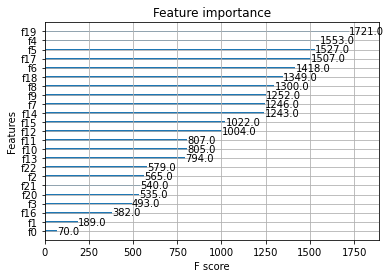

In [22]:
plot_importance(clf, importance_type =  'weight')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

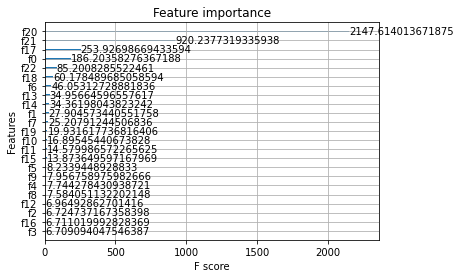

In [23]:
plot_importance(clf, importance_type =  'gain')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

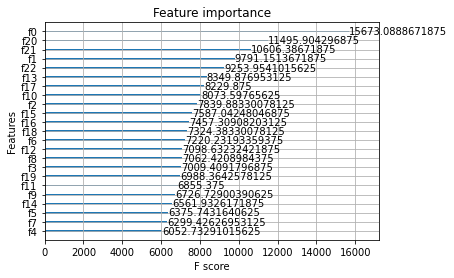

In [24]:
plot_importance(clf, importance_type =  'cover')

In [25]:


use_feat = ["l2_USE", "l1_USE", "sim_USE"]
docvec_feat = ["l2_doc2vec", "l1_doc2vec", "sim_doc2vec"]
sage_feat = ["l2_sage", "l1_sage", "sim_sage"]
base_feat = ["sum_deg", 'diff_deg', "len_abs1", "len_abs2", "len_abs_inters"]
sim_feat = ["adamic_adar", 'ress_alloc', "jacc_coeff"]
authors_feat = ["nb_common_auth", "weighted_common", "nb_auth1", "nb_auth2", "popularity_auth1", "popularity_auth2"]


feature_names = authors_feat + base_feat + use_feat + docvec_feat + sage_feat + sim_feat
feature_names = np.array(feature_names)

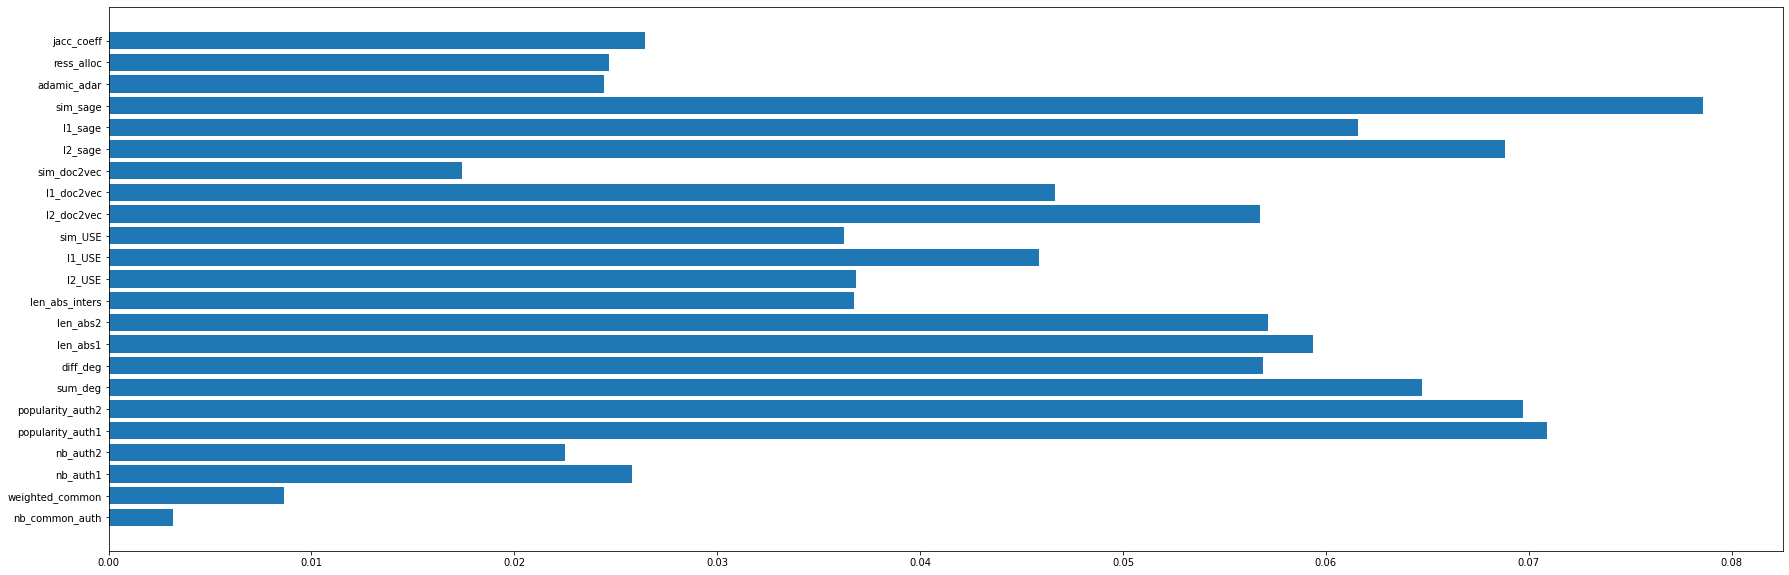

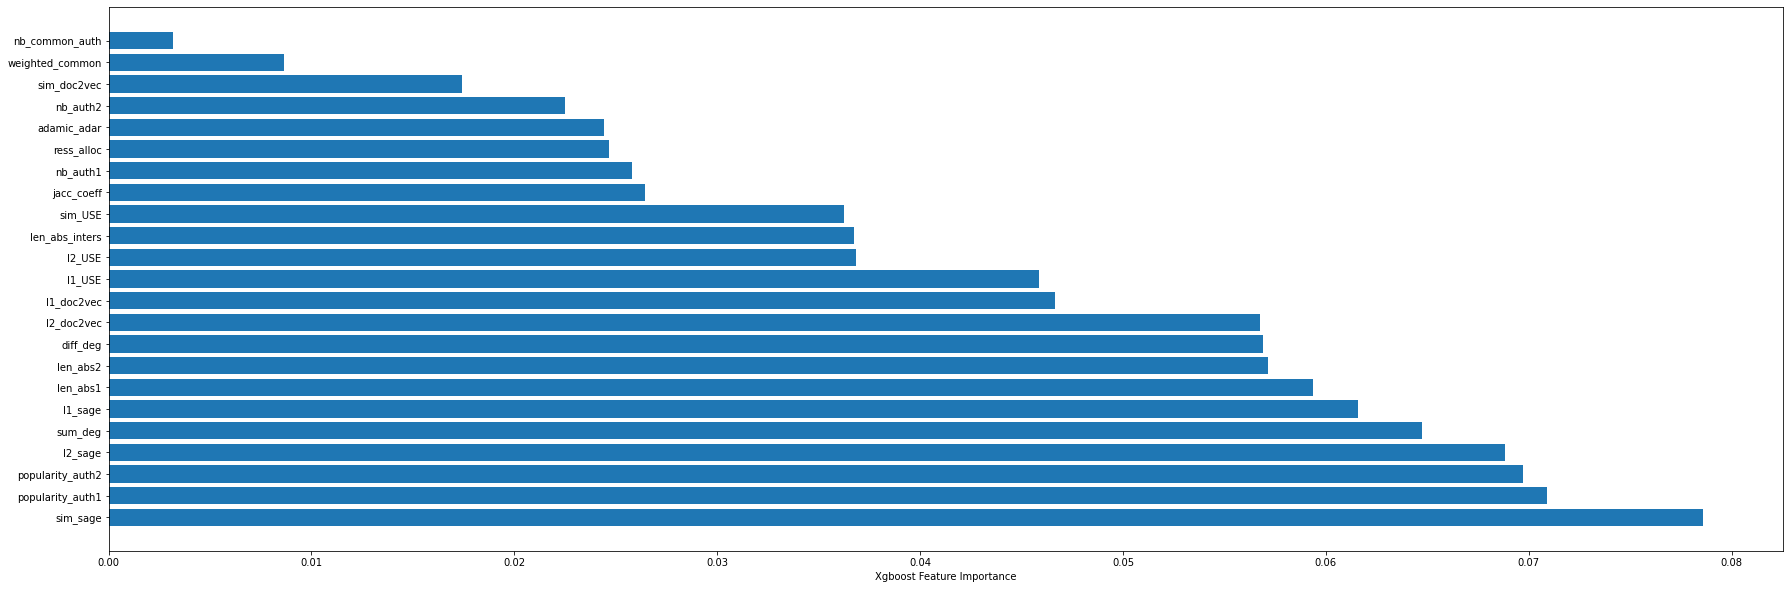

In [26]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (30,10)
plt.barh(feature_names, clf.feature_importances_)
plt.show()
sorted_idx = clf.feature_importances_.argsort()[::-1]
plt.barh(feature_names[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()


# submit

In [27]:
# Read test data. Each sample is a pair of nodes
node_pairs = list()
with open('../input/citation-prediction-altegrad/test.txt', 'r') as f:
    for line in f:
        t = line.split(',')
        node_pairs.append((int(t[0]), int(t[1])))

In [28]:
with open('../input/altegrad-use/USE_embedding.npy', 'rb') as f:
    vecs = np.load(f)
    print(vecs.shape)

X_valid_USE = give_features_from_embedding(vecs, node_pairs)

del vecs

gc.collect()

(138499, 512)


11181

In [29]:
docVec = gensim.models.doc2vec.Doc2Vec.load('../input/altegrad-gensim-draft/docVec.model')
vecs = docVec.dv.get_normed_vectors()
del docVec

X_valid_docVec = give_features_from_embedding(vecs, node_pairs)

del vecs

gc.collect()

45

In [30]:
#with open('../input/marine-sub/embeddingSAGE.npy', 'rb') as f:
with open('../input/sage-v2/embeddingSAGE.npy', 'rb') as f:
    vecs = np.load(f)
    print(vecs.shape)


X_valid_SAGE = give_features_from_embedding(vecs, node_pairs)

del vecs

gc.collect()

(138499, 16)


29

In [31]:
authors_per_node = [] # for hot encoder
author_dic = {} # attribute a number to all authors
count_authors = 0
nodes_per_author = {}

with open(AUTHORS_LIST_PATH, 'r', errors = 'strict') as f:
    for line in f:
        #do stuff
        node, authors = line.split('|--|')
        
        #process errors
        authors = unidecode.unidecode(authors)

        #', -'
        authors_split = process_authors_split(authors)
        authors_node = []

        for author in authors_split:
            if author not in author_dic:
                author_dic[author] = count_authors
                count_authors += 1
            authors_node.append(author_dic[author])
            
            l = nodes_per_author.get(author_dic[author], [])
            nodes_per_author[author_dic[author]] = l + [int(node)]
            
        authors_per_node.append(authors_node)

print("previous author count", count_authors)
count_authors = 0
new_author_dic = {}
new_nodes_per_author = {}
authors_per_node = [] # for hot encoder

with open(AUTHORS_LIST_PATH, 'r', errors = 'strict') as f:
    for line in f:
        #do stuff
        node, authors = line.split('|--|')
        
        #process errors
        authors = unidecode.unidecode(authors)

        #', -'
        authors_split = process_authors_split(authors)
        authors_node = []

        for author in authors_split:
            if len(nodes_per_author.get(author_dic[author], []))>1 or len(authors_split) == 1:
                if author not in new_author_dic:
                    new_author_dic[author] = count_authors
                    count_authors += 1
                authors_node.append(new_author_dic[author])
                
                l = new_nodes_per_author.get(new_author_dic[author], [])
                new_nodes_per_author[new_author_dic[author]] = l + [int(node)]
                        
        authors_per_node.append(authors_node)
        
print("new author count", count_authors)

X_valid_authors = give_authors_features(authors_per_node,  node_pairs, new_nodes_per_author)

del authors_per_node, author_dic, new_nodes_per_author, new_author_dic

gc.collect()

previous author count 106201
new author count 51487


0

In [32]:
# Read the abstract of each paper
abstracts = dict()
with open("../input/citation-prediction-altegrad/abstracts.txt", 'r') as f:
    for line in f:
        node, abstract = line.split('|--|')
        abstracts[int(node)] = abstract

# Map text to set of terms
for node in abstracts:
    abstracts[node] = set(gensim.utils.simple_preprocess(abstracts[node]))
    
X_valid_baseline = give_features_baseline(training_graph, node_pairs, abstracts = abstracts)

del abstracts

gc.collect()


0

In [33]:
X_valid_sim = give_features_from_list_pairs(training_graph, node_pairs)

In [34]:
X_valid = np.c_[X_valid_authors, X_valid_baseline, X_valid_USE, X_valid_docVec, X_valid_SAGE, X_valid_sim]
print(X_valid.shape)

(106692, 23)


In [35]:
y_pred = clf.predict_proba(X_valid)
print(y_pred.shape, y_pred[:5], clf.predict(X_valid)[:5])
y_pred = y_pred[:,1]

# Write predictions to a file
predictions = zip(range(len(y_pred)), y_pred)
with open("submission.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for row in predictions:
        csv_out.writerow(row) 

(106692, 2) [[0.02414918 0.9758508 ]
 [0.9592732  0.04072678]
 [0.21129203 0.788708  ]
 [0.02728033 0.97271967]
 [0.95359284 0.04640716]] [1. 0. 1. 1. 0.]
